## Processing with RN data obtained from forest sites

# Load all data from .xlsx file

In [1]:
# Import main libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap

In [2]:
# Block warnings messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load biomass dataset
site_data = '../02_input_data/RN_sites_data_2024.xlsx'
df = pd.read_excel(site_data, sheet_name='RN_filtration_data')
df.head()

,Ідентифікатор,Site #,Species,Species_ID,Ntrees at site,% composition,D_cm,H_m,G_m2_ha,N_ha,...,T_ag_Cs,ln_T_ag_Cs,T_ag_Sr,ln_T_ag_Sr,AEDR_count,AEDR_mean,AEDR_median,AEDR_std,Distance_km,Azimuth
0,81,001_2021,Pine,0,23,100.000000,26.060965,25.423284,49.081648,920,...,0.792857,-0.232112,8.990000,2.196113,26,3.524231,3.530,0.235489,5.926403,249
1,219,002_2021,Pine,0,60,90.178571,4.303100,4.705979,8.731641,6000,...,1.565517,0.448216,24.191919,3.186019,15,3.830667,3.780,0.166272,6.018960,249
2,224,003_2021,Pine,0,44,100.000000,28.142898,27.556869,54.703060,880,...,0.431579,-0.840305,6.800000,1.916923,28,0.483571,0.475,0.068931,13.046428,189
3,228,004_2021,Pine,0,23,100.000000,14.953551,8.506028,40.420188,2300,...,0.123529,-2.091276,2.460000,0.900161,20,0.364500,0.365,0.029576,12.741627,189
4,232,005_2021,Pine,0,26,100.000000,7.208435,3.425669,2.120687,520,...,0.221212,-1.508633,6.629225,1.891488,18,0.333333,0.345,0.036515,12.893213,189


# List of all parameters for est. of bioproductivity and RN content
"""

All parameters:
'Species', 'Species_ID', '% composition', 'D_cm', 'H_m', 'G_m2_ha',
                                    'Origin', 'Origin_ID','A_year', 'D_live_cm', 'H_live_m', 'G_live_m2_ha',
                                    'F_Soil_ID', 'M_Soil', 'AEDR_mean', 'Distance_km', 'Azimuth',
                                    'Cs_2021_kBq_m', 'Sr_2021_kBq_m', 'ln_A_Cs', 'ln_A_Sr', 
                                    'T_ag_Cs', 'ln_T_ag_Cs', 'T_ag_Sr', 'ln_T_ag_Sr'
"""

In [4]:
# Selecting main working parameters
select = pd.DataFrame(df, columns=['Species', 'Species_ID', '% composition', 'D_cm', 'H_m', 'G_m2_ha',
                                    'Origin', 'Origin_ID','A_year',
                                    'F_Soil_ID', 'M_Soil', 'AEDR_mean', 'Distance_km', 'Azimuth',
                                    'Cs_2021_kBq_m', 'Sr_2021_kBq_m', 'ln_A_Cs', 'ln_A_Sr', 
                                    'ln_T_ag_Cs', 'ln_T_ag_Sr'])
            
'''
In "Species_ID" column: "0" is Pine, "1" is Spruce, "2" is Birch, "3" is Alder, "4" is Aspen, "5" is Oak
In "Origin_ID" column: "0.0" is nutural stand, "1.0" is artificial stand
'''

# Show the first five columns
select.head()

,Species,Species_ID,% composition,D_cm,H_m,G_m2_ha,Origin,Origin_ID,A_year,F_Soil_ID,M_Soil,AEDR_mean,Distance_km,Azimuth,Cs_2021_kBq_m,Sr_2021_kBq_m,ln_A_Cs,ln_A_Sr,ln_T_ag_Cs,ln_T_ag_Sr
0,Pine,0,100.000000,26.060965,25.423284,49.081648,a,1,68,1,2,3.524231,5.926403,249,2800.0,1000.000000,7.705262,9.103868,-0.232112,2.196113
1,Pine,0,90.178571,4.303100,4.705979,8.731641,n,0,15,1,2,3.830667,6.018960,249,2900.0,990.000000,8.420682,10.083724,0.448216,3.186019
2,Pine,0,100.000000,28.142898,27.556869,54.703060,n,0,69,1,2,0.483571,13.046428,189,380.0,90.000000,5.099866,6.416732,-0.840305,1.916923
3,Pine,0,100.000000,14.953551,8.506028,40.420188,n,0,15,2,2,0.364500,12.741627,189,340.0,150.000000,3.737670,5.910797,-2.091276,0.900161
4,Pine,0,100.000000,7.208435,3.425669,2.120687,n,0,10,2,2,0.333333,12.893213,189,330.0,69.993095,4.290459,6.139885,-1.508633,1.891488


# Pre-analysis of parameters

In [5]:
# Information on all columns of data frame
select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Species        209 non-null    object 
 1   Species_ID     209 non-null    int64  
 2   % composition  209 non-null    float64
 3   D_cm           209 non-null    float64
 4   H_m            209 non-null    float64
 5   G_m2_ha        209 non-null    float64
 6   Origin         209 non-null    object 
 7   Origin_ID      209 non-null    int64  
 8   A_year         209 non-null    int64  
 9   F_Soil_ID      209 non-null    int64  
 10  M_Soil         209 non-null    int64  
 11  AEDR_mean      209 non-null    float64
 12  Distance_km    209 non-null    float64
 13  Azimuth        209 non-null    int64  
 14  Cs_2021_kBq_m  209 non-null    float64
 15  Sr_2021_kBq_m  209 non-null    float64
 16  ln_A_Cs        209 non-null    float64
 17  ln_A_Sr        209 non-null    float64
 18  ln_T_ag_Cs

In [6]:
# Discribe statistic of forest sites by species and origin
df.groupby(["Species"])["ln_A_Cs", "ln_A_Sr"].describe()

ln_A_Cs                                                              \
          count      mean       std       min       25%       50%       75%   
Species                                                                       
Alder      13.0  6.249674  1.661129  3.295837  5.840642  6.040255  6.940222   
Aspen       9.0  5.584313  3.039601  2.708050  3.295837  4.204693  6.729824   
Birch      45.0  5.737563  2.249143  2.079442  3.761200  6.173786  7.229839   
Oak         7.0  6.900674  2.917841  2.397895  4.966038  7.753624  9.021902   
Pine      130.0  6.066275  1.963371  1.504077  4.358932  6.564371  7.374614   
Red oak     3.0  3.445685  0.588708  2.833213  3.164860  3.496508  3.751920   
Robinia     1.0  4.394449       NaN  4.394449  4.394449  4.394449  4.394449   
Spruce      1.0  5.176150       NaN  5.176150  5.176150  5.176150  5.176150   

                   ln_A_Sr                                                    \
               max   count      mean       std       min       25%       50%   
Species                                                                        
Alder     9.287301    13.0  6.055811  1.449620  4.094345  4.442651  6.302619   
Aspen    11.366743     9.0  7.575485  2.597130  4.615121  5.209486  7.870930   
Birch    10.332018    45.0  7.671630  2.317833  2.660260  5.752573  7.749322   
Oak      10.177324     7.0  7.188390  2.638333  3.871201  5.248545  7.766417   
Pine     10.468801   130.0  7.470846  1.889243  2.406945  6.165469  7.588295   
Red oak   4.007333     3.0  4.697638  0.334751  4.418841  4.512005  4.605170   
Robinia   4.394449     1.0  7.265430       NaN  7.265430  7.265430  7.265430   
Spruce    5.176150     1.0  7.783224       NaN  7.783224  7.783224  7.783224   

                              
              75%        max  
Species                       
Alder    7.286192   7.649693  
Aspen    8.881836  11.180246  
Birch    8.995909  13.864301  
Oak      8.529114  11.125791  
Pine     8.730280  12.687263  
Red oak  4.837037   5.068904  
Robinia  7.265430   7.265430  
Spruce   7.783224   7.783224

In [7]:
# Descriptive statistics of main parameters
select.describe()

,Species_ID,% composition,D_cm,H_m,G_m2_ha,Origin_ID,A_year,F_Soil_ID,M_Soil,AEDR_mean,Distance_km,Azimuth,Cs_2021_kBq_m,Sr_2021_kBq_m,ln_A_Cs,ln_A_Sr,ln_T_ag_Cs,ln_T_ag_Sr
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,1.057416,94.337925,17.770981,16.978858,30.000765,0.454545,47.464115,1.918660,2.220096,2.526858,14.640059,174.296651,2588.391812,738.540435,5.964225,7.381811,-0.696999,2.239622
std,1.524339,14.155594,8.921738,6.832292,15.907971,0.499125,24.724635,0.634039,0.692944,4.756383,12.363729,99.912885,4938.371798,1556.255010,2.095016,2.042856,1.294511,0.973844
min,0.000000,20.805369,1.914854,2.704460,0.259356,0.000000,10.000000,1.000000,0.000000,0.110000,3.998568,9.000000,22.000000,1.000000,1.504077,2.406945,-5.130702,-0.784714
25%,0.000000,96.775081,11.601519,12.401789,17.519173,0.000000,30.000000,2.000000,2.000000,0.460000,6.562497,56.000000,390.000000,29.466637,4.110874,5.752573,-1.456701,1.633535
50%,0.000000,100.000000,16.817809,17.466646,30.845307,0.000000,45.000000,2.000000,2.000000,0.756000,9.203749,189.000000,710.000000,210.000000,6.309918,7.506592,-0.608351,2.301556
75%,2.000000,100.000000,22.264253,21.414562,42.817263,1.000000,60.000000,2.000000,3.000000,2.401667,20.865459,261.000000,2400.000000,620.000000,7.306531,8.846497,0.288154,2.867382
max,5.000000,100.000000,52.228464,34.048688,66.922093,1.000000,150.000000,3.000000,4.000000,36.591739,57.286577,342.000000,35200.000000,10500.000000,11.366743,13.864301,1.645806,5.227895


# Selecting working columns for the XGBoost algorithms

In [8]:
# Choosing the predictor and independent variables
predictor = "ln_T_ag_Sr"
indep_variables = ['Species_ID','D_cm', 'H_m', 'G_m2_ha', 'A_year',
    'Origin_ID', 'F_Soil_ID', 'M_Soil']


In [9]:
# Delete empty rows from the working column in a dataframe
nan_value = float("NaN")
select.replace("", nan_value, inplace=True)
select.dropna(subset = [predictor], inplace=True) # IMPOTANT - input name of column
print(select)

    Species  Species_ID  % composition       D_cm        H_m    G_m2_ha  \
0      Pine           0     100.000000  26.060965  25.423284  49.081648   
1      Pine           0      90.178571   4.303100   4.705979   8.731641   
2      Pine           0     100.000000  28.142898  27.556869  54.703060   
3      Pine           0     100.000000  14.953551   8.506028  40.420188   
4      Pine           0     100.000000   7.208435   3.425669   2.120687   
..      ...         ...            ...        ...        ...        ...   
204   Aspen           4      99.930119  11.401754  14.676282  17.972410   
205   Birch           2     100.000000   7.912790  13.818368  19.279495   
206    Pine           0     100.000000  16.041613  17.515821  31.533411   
207    Pine           0      96.775081  14.946465  18.178975  44.220927   
208    Pine           0     100.000000  15.387224  17.673021  55.824342   

    Origin  Origin_ID  A_year  F_Soil_ID  M_Soil  AEDR_mean  Distance_km  \
0        a          1  

In [10]:
# We select independent variables and predicting parameter 
X = pd.DataFrame(select, columns=indep_variables)
y = pd.DataFrame(select, columns=[predictor])

In [11]:
# Columns in "X" data collections
X.head()

,Species_ID,D_cm,H_m,G_m2_ha,A_year,Origin_ID,F_Soil_ID,M_Soil
0,0,26.060965,25.423284,49.081648,68,1,1,2
1,0,4.303100,4.705979,8.731641,15,0,1,2
2,0,28.142898,27.556869,54.703060,69,0,1,2
3,0,14.953551,8.506028,40.420188,15,0,2,2
4,0,7.208435,3.425669,2.120687,10,0,2,2


In [12]:
# Columns in "y" data collections
y.head()

,ln_T_ag_Sr
0,2.196113
1,3.186019
2,1.916923
3,0.900161
4,1.891488


# Create first XGBoost model for estimate varibiality of output stats

In [13]:
#  Importing the main library for building model and its analysis
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.datasets import make_classification

In [14]:
# K-Folds cross-validation for estimation "quality" of input data for building model
X_kfold = pd.DataFrame(X).to_numpy()
y_kfold = pd.DataFrame(y).to_numpy()

In [15]:
# Function for comparing datasets on homogeneity 
def display_scores(scores):
    print("    Scores: {0}\n    Mean: {1:.3f}\n    Std: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [16]:
# Output results of K-Folds cross-validation for XGBoost model
kfold = KFold(n_splits=3, shuffle=True)
scores = []
for train_index, test_index in kfold.split(X_kfold):   
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    scores.append(r2_score(y_test, y_pred))
    
print('R square (R2): \n')
display_scores((scores))
print('\n', 20*'-')


scores = []
for train_index, test_index in kfold.split(X_kfold):   
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
      
    scores.append(mean_squared_error(y_test, y_pred))
    
print('Root-mean-square error (RMSE): \n')
display_scores(np.sqrt(scores))
print('\n', 20*'-')

scores = []
for train_index, test_index in kfold.split(X_kfold):   
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    scores.append(mean_absolute_error(y_test, y_pred))

print('Mean absolute error (MAE): \n')
display_scores((scores))
print('\n', 20*'-')

R square (R2): 

    Scores: [0.06112154499906963, 0.24081012254387724, 0.3192896196885662]
    Mean: 0.207
    Std: 0.108

 --------------------
Root-mean-square error (RMSE): 

    Scores: [0.82662874 0.85797389 0.87780186]
    Mean: 0.854
    Std: 0.021

 --------------------
Mean absolute error (MAE): 

    Scores: [0.7395139264336318, 0.5973820213592429, 0.6504746784134992]
    Mean: 0.662
    Std: 0.059

 --------------------


# Add optimal hyperparameters for XGBoost model

In [17]:
# Hyperparameters data for the next step/stage
p1 = 0.7327675639923839                   # colsample_bytree
print('Colsample_bytree: ' + str(p1))

p2 = 0.04558812083388075                  # gamma
print('Gamma: ' + str(p2))

p3 = 0.10198012556475948                  # learning_rate
print('Learning_rate: ' + str(p3))

p4 = 2                                    # max_depth
print('Max_depth: ' + str(p4))

p5 = 79                                   # n_estimators
print('N_estimators: ' + str(p5))

p6 = 0.811521748868657                    # subsample
print('Subsample: ' + str(p6))

Colsample_bytree: 0.7327675639923839
Gamma: 0.04558812083388075
Learning_rate: 0.10198012556475948
Max_depth: 2
N_estimators: 79
Subsample: 0.811521748868657


# Estimation of predictive quality to basic XGBoost models using Loops

In [18]:
# Aggregate parameters
aggr_y=[]
aggr_y_pred=[]

aggr_optimal_n=[]
aggr_bias=[]
aggr_rel_bias=[]
aggr_rmse=[]
aggr_rel_rmse=[]
aggr_mse=[]
aggr_R_square=[]

exp_aggr_optimal_n=[]
exp_aggr_bias=[]
exp_aggr_rel_bias=[]
exp_aggr_rmse=[]
exp_aggr_rel_rmse=[]
exp_aggr_mse=[]
exp_aggr_R_square=[]

aggr_Shap_values=pd.DataFrame()

# Body loop
for i in range(200):
    
    # Generate test and training samples
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    #exp_y_train = np.exp(y_train)
    exp_y_test = np.exp(y_test)
    
    # Implementation of the scikit-learn API for XGBoost regression
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=p1, gamma=p2, learning_rate=p3, 
                          max_depth=p4, n_estimators=p5, subsample=p6, eval_metric=["rmse"])
    
    # Fitting the model 
    xgb_model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_train, y_train), (X_test, y_test)])
    
    # learning dynamics
    y_pred = xgb_model.predict(X_test, ntree_limit=xgb_model.best_ntree_limit)
    
    exp_y_pred = np.exp(y_pred)
    
    # Iteration with the best result
    optimal_n= xgb_model.best_ntree_limit-1
    
    # Convert data to 'array' type
    conv_y_pred = pd.DataFrame(y_pred) # Double transformation
    y_pred2 = conv_y_pred.values
    y_test2 = y_test.values
    
    exp_y_pred2 = np.exp(y_pred2)
    exp_y_test2 = np.exp(y_test2)
    
    # Intermediate results
    n_sample = len(y_pred2)
    y_mean_sample = y_test.sum() / n_sample
    
    exp_y_mean_sample = exp_y_test.sum() / n_sample
    
    # Calculation of bias
    diff = y_pred2 - y_test2
    bias = diff.sum()/n_sample
    rel_bias = bias/y_mean_sample*100
    
    exp_diff = exp_y_pred2 - exp_y_test2
    exp_bias = exp_diff.sum()/n_sample
    exp_rel_bias = exp_bias/exp_y_mean_sample*100
    
    # Calculation of RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rel_rmse = rmse/y_mean_sample*100 
    
    exp_rmse = np.sqrt(mean_squared_error(exp_y_test, exp_y_pred))
    exp_rel_rmse = exp_rmse/exp_y_mean_sample*100 
    
    # Calculation of MSE
    mse = mean_squared_error(y_test, y_pred)   
    
    exp_mse = mean_squared_error(exp_y_test, exp_y_pred)
    
    # Calculation of Square R
    diff_with_mean = []
    exp_diff_with_mean = []
    
    for i in range(n_sample):
        interm = y_test2[i][0] - y_mean_sample
        diff_with_mean.append(interm**2)

    RSS = np.sum((y_test2 - y_pred2)**2)
    TSS = (np.sum(diff_with_mean))
    R_square = 1 - (RSS / TSS)
    
    for i in range(n_sample):
        exp_interm = exp_y_test2[i][0] - exp_y_mean_sample
        exp_diff_with_mean.append(exp_interm**2)

    exp_RSS = np.sum((exp_y_test2 - exp_y_pred2)**2)
    exp_TSS = np.sum(exp_diff_with_mean)
    
    exp_R_square = 1 - (exp_RSS / exp_TSS)
    
    #Calculation of SHAP-values
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_train)
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['Feature','Importance'])
       
    
    #Add values to lists
    aggr_y.append(y_test)
    aggr_y_pred.append(conv_y_pred)    
    
    aggr_optimal_n.append(optimal_n)
    aggr_bias.append(bias)
    aggr_rel_bias.append(rel_bias)
    aggr_rmse.append(rmse)
    aggr_rel_rmse.append(rel_rmse)
    aggr_mse.append(mse)
    aggr_R_square.append(R_square)
    
    exp_aggr_bias.append(exp_bias)
    exp_aggr_rel_bias.append(exp_rel_bias)
    exp_aggr_rmse.append(exp_rmse)
    exp_aggr_rel_rmse.append(exp_rel_rmse)
    exp_aggr_mse.append(exp_mse)
    exp_aggr_R_square.append(exp_R_square)
    
    aggr_Shap_values = aggr_Shap_values.append(feature_importance, ignore_index=True)
    
# Intermedia data to calculate CI
n_train = len(y_train)
n_test = len(y_test)

[0]	validation_0-rmse:1.83807	validation_1-rmse:1.77167
[1]	validation_0-rmse:1.69315	validation_1-rmse:1.63601
[2]	validation_0-rmse:1.56993	validation_1-rmse:1.51379
[3]	validation_0-rmse:1.45548	validation_1-rmse:1.40534
[4]	validation_0-rmse:1.36032	validation_1-rmse:1.30916
[5]	validation_0-rmse:1.27587	validation_1-rmse:1.22608
[6]	validation_0-rmse:1.20345	validation_1-rmse:1.15866
[7]	validation_0-rmse:1.13560	validation_1-rmse:1.09392
[8]	validation_0-rmse:1.07995	validation_1-rmse:1.03899
[9]	validation_0-rmse:1.02926	validation_1-rmse:0.99539
[10]	validation_0-rmse:0.98289	validation_1-rmse:0.95399
[11]	validation_0-rmse:0.94235	validation_1-rmse:0.92111
[12]	validation_0-rmse:0.90887	validation_1-rmse:0.89141
[13]	validation_0-rmse:0.88186	validation_1-rmse:0.87377
[14]	validation_0-rmse:0.85676	validation_1-rmse:0.85327
[15]	validation_0-rmse:0.82909	validation_1-rmse:0.82839
[16]	validation_0-rmse:0.80973	validation_1-rmse:0.81460
[17]	validation_0-rmse:0.79254	validation

# Create plot with predicted values for test samples (after 200 iteration)

In [19]:
# Preprocessing
pd_aggr_y = pd.concat(aggr_y, join="inner")
pd_aggr_y['Obs'] = pd_aggr_y.index

pd_aggr_y_pred = pd.concat(aggr_y_pred, join="inner")

results_y = pd.concat([pd_aggr_y.reset_index(), pd_aggr_y_pred.reset_index()], axis=1)

n_all_y = len(results_y['Obs'])

stat_y = results_y.groupby(['Obs'])[predictor, 0].describe(percentiles=[.16, .5, .84])

l_sd_y_pred = stat_y[0]['50%'] - stat_y[0]['16%']
t_sd_y_pred = stat_y[0]['84%'] - stat_y[0]['50%']

n_stat_y = len(stat_y[0]['50%'])

In [20]:
"""
Assessment of linear approximation between observations and 
predict values and estimation of parameters uncertainties for this regression
"""
# Load libraries elements
from scipy.optimize import curve_fit   
from scipy import stats

# pip install uncertainties, if needed
try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    try:
        from pip import main as pipmain
    except:
        from pip._internal import main as pipmain
    pipmain(['install','uncertainties'])
    import uncertainties.unumpy as unp
    import uncertainties as unc

In [21]:
# Convert input data
x_test_conv = np.array(results_y[predictor])
x_test_convert = np.array([None]*n_all_y)
for i in range(n_all_y):
    x_test_convert[i] = np.float64(x_test_conv[i])

x_plot = x_test_convert
y_plot = results_y[0]
n = n_all_y

# Function for fitting a linear curve and estimating its parameters
def f(x_plot, a0, a1):
    return a0 + a1 * x_plot

popt, pcov = curve_fit(f, x_plot, y_plot)

R^2: 0.361
Uncertainty
a0: 1.464+/-0.077
a1: 0.335+/-0.033


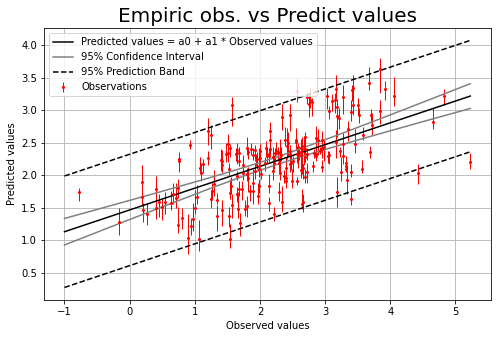

In [22]:
# Building linear a graph and calculation uncertainties

# retrieve parameter values
a0 = popt[0]
a1 = popt[1]

# compute r^2
r2 = 1.0-(sum((y_plot-f(x_plot, a0, a1)) ** 2)/((n - 1.0)*np.var(y_plot, ddof = 1)))
print(f'R^2: {r2:.3f}')

# calculate parameter confidence interval
a0, a1 = unc.correlated_values(popt, pcov)
index_a0 = str(a0).find('+/-')
index_a1 = str(a1).find('+/-')
am_a0 = str(a0)[0:index_a0]
ci_a0 = str(a0)[index_a0+3:]
am_a1 = str(a1)[0:index_a1]
ci_a1 = str(a1)[index_a1+3:]

print('Uncertainty')
print(f'a0: {am_a0}+/-{round(float(ci_a0)*(n_all_y/n_stat_y)**0.5, 3)}')
print(f'a1: {am_a1}+/-{round(float(ci_a1)*(n_all_y/n_stat_y)**0.5, 3)}')

# plot data
plt.figure(figsize =(8, 5))
plt.errorbar(stat_y[predictor]['mean'], stat_y[0]['50%'], yerr=[list(l_sd_y_pred), list(t_sd_y_pred)], c = 'red', fmt='o', lw=1, ms=2, label='Observations')
plt.yscale('linear')

# calculate regression confidence interval
px = np.linspace(-1, max(x_plot), 100)
py = a0 + a1 * px
nom = unp.nominal_values(py)
std = unp.std_devs(py)

# estimation uncertenlies intervals
def predband(x_plot, xd, yd, p, func, conf=0.95):
    # x_plot = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x_plot - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x_plot, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

lpb, upb = predband(px, x_plot, y_plot, popt, f, conf=0.95)

# plot the regression
plt.plot(px, nom, c='black', label='Predicted values = a0 + a1 * Observed values')

# uncertainty lines (95% confidence)
plt.plot(px, nom - 1.96 * std * (n_all_y**0.5)/(n_stat_y**0.5), c='gray',\
         label='95% Confidence Interval')
plt.plot(px, nom + 1.96 * std * (n_all_y**0.5)/(n_stat_y**0.5), c='gray')

# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('Predicted values')
plt.xlabel('Observed values')
plt.grid(True)
plt.legend(loc='best')
plt.title('Empiric obs. vs Predict values', fontsize=20, color="black")
plt.show()

# Uncertainty parameters and confidence intervals

In [23]:
# Intermedia ratio for calculation CI
CIR = 2/((n_test + n_train)/n_test)**0.5

In [24]:
# Statistic for SHAP-values

number_iteration = len(aggr_Shap_values.groupby(['Feature']))
shap_list = aggr_Shap_values.groupby(['Feature'])


for i in range(number_iteration):
    itr_mean = round(np.mean(list(shap_list)[i][1].iloc[0:, 1]), 3)
    itr_Q50 = round(np.quantile(list(shap_list)[i][1].iloc[0:, 1], 0.50), 3)
    itr_Q16 = round(np.quantile(list(shap_list)[i][1].iloc[0:, 1], 0.16), 3)
    itr_Q84 = round(np.quantile(list(shap_list)[i][1].iloc[0:, 1], 0.84), 3)
    itr_l = (itr_Q50 - itr_Q16)*CIR
    l_CI = itr_Q50 - itr_l
    itr_t = (itr_Q84 - itr_Q50)*CIR
    t_CI = itr_Q50 + itr_t    
    print(f"SHAP-values for: {list(shap_list)[i][0]}: mean - {itr_mean}, median - {itr_Q50}, CI - [{round(l_CI, 3)}-{round(t_CI, 3)}]\n")        

SHAP-values for: A_year: mean - 0.115, median - 0.116, CI - [0.09-0.143]

SHAP-values for: D_cm: mean - 0.306, median - 0.306, CI - [0.266-0.346]

SHAP-values for: F_Soil_ID: mean - 0.147, median - 0.147, CI - [0.116-0.177]

SHAP-values for: G_m2_ha: mean - 0.048, median - 0.046, CI - [0.029-0.065]

SHAP-values for: H_m: mean - 0.162, median - 0.161, CI - [0.127-0.197]

SHAP-values for: M_Soil: mean - 0.079, median - 0.076, CI - [0.051-0.108]

SHAP-values for: Origin_ID: mean - 0.069, median - 0.065, CI - [0.036-0.1]

SHAP-values for: Species_ID: mean - 0.093, median - 0.092, CI - [0.07-0.118]



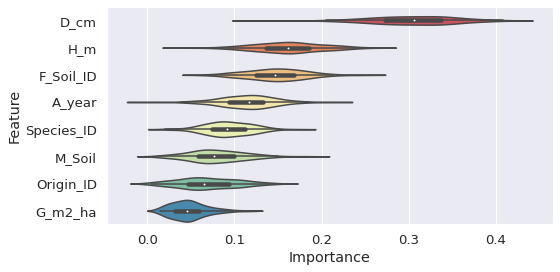

In [60]:
sns.set(font_scale=1.2)
sns.violinplot(x="Importance", y="Feature", data=aggr_Shap_values, inner="box", palette="Spectral", order=['D_cm', 'H_m', 'F_Soil_ID', 'A_year', 
  'Species_ID', 'M_Soil', 'Origin_ID', 'G_m2_ha'])
sns.set(rc={'figure.figsize':(8,4)})
plt.show()

In [28]:
# Aggregate stat
# optimal number of iterations
aggr_optimal_n_mean = np.mean(aggr_optimal_n)
aggr_optimal_n_Q025 = np.quantile(aggr_optimal_n, 0.025)
aggr_optimal_n_Q16 = np.quantile(aggr_optimal_n, 0.16)
aggr_optimal_n_Q50 = np.quantile(aggr_optimal_n, 0.50)
aggr_optimal_n_Q84 = np.quantile(aggr_optimal_n, 0.84)
aggr_optimal_n_Q975 = np.quantile(aggr_optimal_n, 0.975)

# bias
aggr_bias_mean = np.mean(aggr_bias)
aggr_bias_Q025 = np.quantile(aggr_bias, 0.025)
aggr_bias_Q16 = np.quantile(aggr_bias, 0.16)
aggr_bias_Q50 = np.quantile(aggr_bias, 0.50)
aggr_bias_Q84 = np.quantile(aggr_bias, 0.84)
aggr_bias_Q975 = np.quantile(aggr_bias, 0.975)

aggr_rel_bias_mean = np.mean(aggr_rel_bias)
aggr_rel_bias_Q025 = np.quantile(aggr_rel_bias, 0.025)
aggr_rel_bias_Q16 = np.quantile(aggr_rel_bias, 0.16)
aggr_rel_bias_Q50 = np.quantile(aggr_rel_bias, 0.50)
aggr_rel_bias_Q84 = np.quantile(aggr_rel_bias, 0.84)
aggr_rel_bias_Q975 = np.quantile(aggr_rel_bias, 0.975)

# RMSE
aggr_rmse_mean = np.mean(aggr_rmse)
aggr_rmse_Q025 = np.quantile(aggr_rmse, 0.025)
aggr_rmse_Q16 = np.quantile(aggr_rmse, 0.16)
aggr_rmse_Q50 = np.quantile(aggr_rmse, 0.50)
aggr_rmse_Q84 = np.quantile(aggr_rmse, 0.84)
aggr_rmse_Q975 = np.quantile(aggr_rmse, 0.975)

aggr_rel_rmse_mean = np.mean(aggr_rel_rmse)
aggr_rel_rmse_Q025 = np.quantile(aggr_rel_rmse, 0.025)
aggr_rel_rmse_Q16 = np.quantile(aggr_rel_rmse, 0.16)
aggr_rel_rmse_Q50 = np.quantile(aggr_rel_rmse, 0.50)
aggr_rel_rmse_Q84 = np.quantile(aggr_rel_rmse, 0.84)
aggr_rel_rmse_Q975 = np.quantile(aggr_rel_rmse, 0.975)

# MSE
aggr_mse_mean = np.mean(aggr_mse)
aggr_mse_Q025 = np.quantile(aggr_mse, 0.025)
aggr_mse_Q16 = np.quantile(aggr_mse, 0.16)
aggr_mse_Q50 = np.quantile(aggr_mse, 0.50)
aggr_mse_Q84 = np.quantile(aggr_mse, 0.84)
aggr_mse_Q975 = np.quantile(aggr_mse, 0.975)

# R-square
aggr_R_square_mean = np.mean(aggr_R_square)
aggr_R_square_Q025 = np.quantile(aggr_R_square, 0.025)
aggr_R_square_Q16 = np.quantile(aggr_R_square, 0.16)
aggr_R_square_Q50 = np.quantile(aggr_R_square, 0.50)
aggr_R_square_Q84 = np.quantile(aggr_R_square, 0.84)
aggr_R_square_Q975 = np.quantile(aggr_R_square, 0.975)

# exp_bias
exp_aggr_bias_mean = np.mean(exp_aggr_bias)
exp_aggr_bias_Q025 = np.quantile(exp_aggr_bias, 0.025)
exp_aggr_bias_Q16 = np.quantile(exp_aggr_bias, 0.16)
exp_aggr_bias_Q50 = np.quantile(exp_aggr_bias, 0.50)
exp_aggr_bias_Q84 = np.quantile(exp_aggr_bias, 0.84)
exp_aggr_bias_Q975 = np.quantile(exp_aggr_bias, 0.975)

exp_aggr_rel_bias_mean = np.mean(exp_aggr_rel_bias)
exp_aggr_rel_bias_Q025 = np.quantile(exp_aggr_rel_bias, 0.025)
exp_aggr_rel_bias_Q16 = np.quantile(exp_aggr_rel_bias, 0.16)
exp_aggr_rel_bias_Q50 = np.quantile(exp_aggr_rel_bias, 0.50)
exp_aggr_rel_bias_Q84 = np.quantile(exp_aggr_rel_bias, 0.84)
exp_aggr_rel_bias_Q975 = np.quantile(exp_aggr_rel_bias, 0.975)

# exp_RMSE
exp_aggr_rmse_mean = np.mean(exp_aggr_rmse)
exp_aggr_rmse_Q025 = np.quantile(exp_aggr_rmse, 0.025)
exp_aggr_rmse_Q16 = np.quantile(exp_aggr_rmse, 0.16)
exp_aggr_rmse_Q50 = np.quantile(exp_aggr_rmse, 0.50)
exp_aggr_rmse_Q84 = np.quantile(exp_aggr_rmse, 0.84)
exp_aggr_rmse_Q975 = np.quantile(exp_aggr_rmse, 0.975)

exp_aggr_rel_rmse_mean = np.mean(exp_aggr_rel_rmse)
exp_aggr_rel_rmse_Q025 = np.quantile(exp_aggr_rel_rmse, 0.025)
exp_aggr_rel_rmse_Q16 = np.quantile(exp_aggr_rel_rmse, 0.16)
exp_aggr_rel_rmse_Q50 = np.quantile(exp_aggr_rel_rmse, 0.50)
exp_aggr_rel_rmse_Q84 = np.quantile(exp_aggr_rel_rmse, 0.84)
exp_aggr_rel_rmse_Q975 = np.quantile(exp_aggr_rel_rmse, 0.975)

# exp_MSE
exp_aggr_mse_mean = np.mean(exp_aggr_mse)
exp_aggr_mse_Q025 = np.quantile(exp_aggr_mse, 0.025)
exp_aggr_mse_Q16 = np.quantile(exp_aggr_mse, 0.16)
exp_aggr_mse_Q50 = np.quantile(exp_aggr_mse, 0.50)
exp_aggr_mse_Q84 = np.quantile(exp_aggr_mse, 0.84)
exp_aggr_mse_Q975 = np.quantile(exp_aggr_mse, 0.975)

# exp_R-square
exp_aggr_R_square_mean = np.mean(exp_aggr_R_square)
exp_aggr_R_square_Q025 = np.quantile(exp_aggr_R_square, 0.025)
exp_aggr_R_square_Q16 = np.quantile(exp_aggr_R_square, 0.16)
exp_aggr_R_square_Q50 = np.quantile(exp_aggr_R_square, 0.50)
exp_aggr_R_square_Q84 = np.quantile(exp_aggr_R_square, 0.84)
exp_aggr_R_square_Q975 = np.quantile(exp_aggr_R_square, 0.975)

In [29]:
# Output calculated stat
print("Logarithmically transformed predictive values:")
print(f"Aggregate optimal number of iterations statistic: \n mean: {round(aggr_optimal_n_mean, 3)}, median: {round(aggr_optimal_n_Q50, 3)},\n pred. interval (P(0.025)-P(0.975)): {round(aggr_optimal_n_Q025, 3)}-{round(aggr_optimal_n_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_optimal_n_Q50-((aggr_optimal_n_Q50-aggr_optimal_n_Q16)*CIR), 3)}-{round(aggr_optimal_n_Q50+((aggr_optimal_n_Q84-aggr_optimal_n_Q50)*CIR), 3)} \n***")
print(f"Aggregate bias statistic: \n mean: {round(aggr_bias_mean, 3)}, median: {round(aggr_bias_Q50, 3)},\n pred. interval (P(0.025)-P(0.975)): {round(aggr_bias_Q025, 3)}-{round(aggr_bias_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_bias_Q50-((aggr_bias_Q50-aggr_bias_Q16)*CIR), 3)}-{round(aggr_bias_Q50+((aggr_bias_Q84-aggr_bias_Q50)*CIR), 3)} \n***")
print(f"Aggregate RMSE statistic: \n mean: {round(aggr_rmse_mean, 3)}, median: {round(aggr_rmse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_rmse_Q025, 3)}-{round(aggr_rmse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_rmse_Q50-((aggr_rmse_Q50-aggr_rmse_Q16)*CIR), 3)}-{round(aggr_rmse_Q50+((aggr_rmse_Q84-aggr_rmse_Q50)*CIR), 3)} \n***")
print(f"Aggregate MSE statistic: \n mean: {round(aggr_mse_mean, 3)}, median: {round(aggr_mse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_mse_Q025, 3)}-{round(aggr_mse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_mse_Q50-((aggr_mse_Q50-aggr_mse_Q16)*CIR), 3)}-{round(aggr_mse_Q50+((aggr_mse_Q84-aggr_mse_Q50)*CIR), 3)} \n***")
print(f"Aggregate R^2 statistic: \n mean: {round(aggr_R_square_mean, 3)}, median: {round(aggr_R_square_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_R_square_Q025, 3)}-{round(aggr_R_square_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_R_square_Q50-((aggr_R_square_Q50-aggr_R_square_Q16)*CIR), 3)}-{round(aggr_R_square_Q50+((aggr_R_square_Q84-aggr_R_square_Q50)*CIR), 3)} \n***")
print(f"Aggregate bias(%) statistic: \n mean: {round(aggr_rel_bias_mean, 3)}, median: {round(aggr_rel_bias_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_rel_bias_Q025, 3)}-{round(aggr_rel_bias_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_rel_bias_Q50-((aggr_rel_bias_Q50-aggr_rel_bias_Q16)*CIR), 3)}-{round(aggr_rel_bias_Q50+((aggr_rel_bias_Q84-aggr_rel_bias_Q50)*CIR), 3)} \n***")
print(f"Aggregate RMSE(%) statistic: \n mean: {round(aggr_rel_rmse_mean, 3)}, median: {round(aggr_rel_rmse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_rel_rmse_Q025, 3)}-{round(aggr_rel_rmse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_rel_rmse_Q50-((aggr_rel_rmse_Q50-aggr_rel_rmse_Q16)*CIR), 3)}-{round(aggr_rel_rmse_Q50+((aggr_rel_rmse_Q84-aggr_rel_rmse_Q50)*CIR), 3)} \n***")

print("\nTransformed predictive values into the primary state:")
print(f"Aggregate bias statistic: \n mean: {round(exp_aggr_bias_mean, 3)}, median: {round(exp_aggr_bias_Q50, 3)},\n pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_bias_Q025, 3)}-{round(exp_aggr_bias_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_bias_Q50-((exp_aggr_bias_Q50-exp_aggr_bias_Q16)*CIR), 3)}-{round(exp_aggr_bias_Q50+((exp_aggr_bias_Q84-exp_aggr_bias_Q50)*CIR), 3)} \n***")
print(f"Aggregate RMSE statistic: \n mean: {round(exp_aggr_rmse_mean, 3)}, median: {round(exp_aggr_rmse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_rmse_Q025, 3)}-{round(exp_aggr_rmse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_rmse_Q50-((exp_aggr_rmse_Q50-exp_aggr_rmse_Q16)*CIR), 3)}-{round(exp_aggr_rmse_Q50+((exp_aggr_rmse_Q84-exp_aggr_rmse_Q50)*CIR), 3)} \n***")
print(f"Aggregate MSE statistic: \n mean: {round(exp_aggr_mse_mean, 3)}, median: {round(exp_aggr_mse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_mse_Q025, 3)}-{round(exp_aggr_mse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_mse_Q50-((exp_aggr_mse_Q50-exp_aggr_mse_Q16)*CIR), 3)}-{round(exp_aggr_mse_Q50+((exp_aggr_mse_Q84-exp_aggr_mse_Q50)*CIR), 3)} \n***")
print(f"Aggregate R^2 statistic: \n mean: {round(exp_aggr_R_square_mean, 3)}, median: {round(exp_aggr_R_square_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_R_square_Q025, 3)}-{round(exp_aggr_R_square_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_R_square_Q50-((exp_aggr_R_square_Q50-exp_aggr_R_square_Q16)*CIR), 3)}-{round(exp_aggr_R_square_Q50+((exp_aggr_R_square_Q84-exp_aggr_R_square_Q50)*CIR), 3)} \n***")
print(f"Aggregate bias(%) statistic: \n mean: {round(exp_aggr_rel_bias_mean, 3)}, median: {round(exp_aggr_rel_bias_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_rel_bias_Q025, 3)}-{round(exp_aggr_rel_bias_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_rel_bias_Q50-((exp_aggr_rel_bias_Q50-exp_aggr_rel_bias_Q16)*CIR), 3)}-{round(exp_aggr_rel_bias_Q50+((exp_aggr_rel_bias_Q84-exp_aggr_rel_bias_Q50)*CIR), 3)} \n***")
print(f"Aggregate RMSE(%) statistic: \n mean: {round(exp_aggr_rel_rmse_mean, 3)}, median: {round(exp_aggr_rel_rmse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_rel_rmse_Q025, 3)}-{round(exp_aggr_rel_rmse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_rel_rmse_Q50-((exp_aggr_rel_rmse_Q50-exp_aggr_rel_rmse_Q16)*CIR), 3)}-{round(exp_aggr_rel_rmse_Q50+((exp_aggr_rel_rmse_Q84-exp_aggr_rel_rmse_Q50)*CIR), 3)} \n***")

Logarithmically transformed predictive values:
Aggregate optimal number of iterations statistic: 
 mean: 53.76, median: 55.0,
 pred. interval (P(0.025)-P(0.975)): 22.0-78.0, 
 conf. interval (p-value=0.95): 36.029-72.035 
***
Aggregate bias statistic: 
 mean: -0.018, median: -0.012,
 pred. interval (P(0.025)-P(0.975)): -0.263-0.182, 
 conf. interval (p-value=0.95): -0.141-0.09 
***
Aggregate RMSE statistic: 
 mean: 0.779, median: 0.783, pred. interval (P(0.025)-P(0.975)): 0.621-0.969, 
 conf. interval (p-value=0.95): 0.696-0.856 
***
Aggregate MSE statistic: 
 mean: 0.616, median: 0.613, pred. interval (P(0.025)-P(0.975)): 0.386-0.94, 
 conf. interval (p-value=0.95): 0.485-0.734 
***
Aggregate R^2 statistic: 
 mean: 0.344, median: 0.346, pred. interval (P(0.025)-P(0.975)): 0.07-0.534, 
 conf. interval (p-value=0.95): 0.251-0.439 
***
Aggregate bias(%) statistic: 
 mean: -0.567, median: -0.519, pred. interval (P(0.025)-P(0.975)): -10.768-9.231, 
 conf. interval (p-value=0.95): -6.112-4.

# Analysis of residuals distributions dependents on empirical values of predicted parameter

Text(0.5, 1.0, 'In typical state')

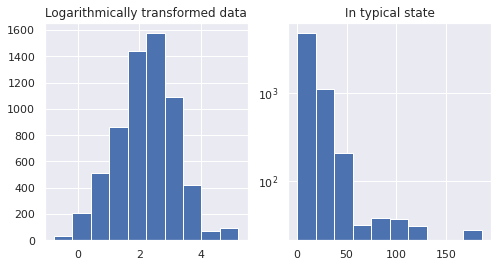

In [30]:
# Preprocessing
results_y['T_exp_empiric'] = np.exp(results_y[predictor])
results_y['T_exp_pred'] = np.exp(results_y[0])

results_y['ln_residuals'] = results_y[predictor] - results_y[0]
results_y['T_exp_residuals'] = results_y['T_exp_empiric'] - results_y['T_exp_pred']
results_y['ln_residuals_%'] =  results_y['ln_residuals'] / results_y[predictor] * 100
results_y['T_exp_residuals_%'] = results_y['T_exp_residuals'] / results_y['T_exp_empiric'] * 100

# plt.hist(results_y[predictor])
# plt.hist(results_y[predictor])
fig, axs = plt.subplots(1, 2)
axs[0].hist(results_y[predictor])
axs[0].set_title('Logarithmically transformed data')
axs[1].hist(results_y['T_exp_empiric'], log=True)
axs[1].set_title('In typical state')
# plt.show() 

In [31]:
# INPORTANT  - added your intervals
ln_intervals = pd.cut(results_y[predictor], [0, 1, 2, 3, 4, 5])
T_exp_intervals = pd.cut(results_y['T_exp_empiric'], [0, 5, 10, 20, 50, 100])

ln_grouped = results_y.groupby(ln_intervals)
T_exp_grouped = results_y.groupby(T_exp_intervals) 

max_obs_in_group = len(results_y)    
    
pre_ln = pd.DataFrame()
pre_T_exp = pd.DataFrame()
pre_rel_ln = pd.DataFrame()
pre_rel_T_exp = pd.DataFrame()

pre_ln = pre_ln.assign(row_number=range(max_obs_in_group))
pre_T_exp = pre_T_exp.assign(row_number=range(max_obs_in_group))
pre_rel_ln = pre_rel_ln.assign(row_number=range(max_obs_in_group))
pre_rel_T_exp = pre_rel_T_exp.assign(row_number=range(max_obs_in_group))

for i in range(len(list(ln_grouped))):
    pre_ln[list(ln_grouped)[i][0]] = pd.Series(list(ln_grouped)[i][1]['ln_residuals'])
    pre_rel_ln[list(ln_grouped)[i][0]] = pd.Series(list(ln_grouped)[i][1]['ln_residuals_%'])

for i in range(len(list(T_exp_grouped))):
    pre_T_exp[list(T_exp_grouped)[i][0]] = pd.Series(list(T_exp_grouped)[i][1]['T_exp_residuals'])
    pre_rel_T_exp[list(T_exp_grouped)[i][0]] = pd.Series(list(T_exp_grouped)[i][1]['T_exp_residuals_%'])

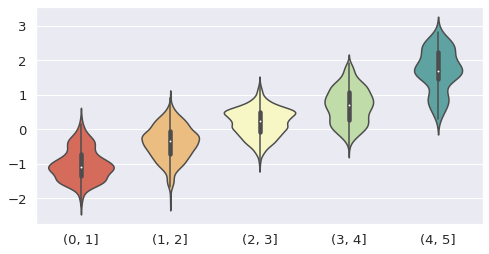

In [32]:
# Plots of residuals versus predicted values
sns.set(font_scale=1.2)
sns.violinplot(data=pre_ln[list(pre_ln.columns)[1:]], inner="box", palette="Spectral")
sns.set(rc={'figure.figsize':(8,4)})
plt.show()

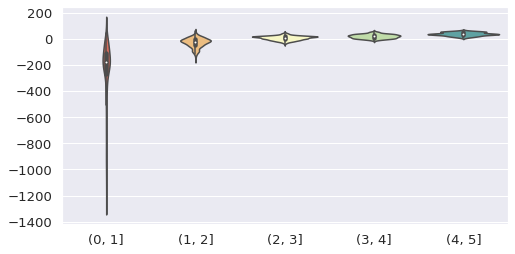

In [33]:
# Plots of relative residuals (in %) versus predicted values
sns.set(font_scale=1.2)
sns.violinplot(data=pre_rel_ln[(pre_rel_ln.columns)[1:]], inner="box", palette="Spectral")
sns.set(rc={'figure.figsize':(8,4)})
plt.show()

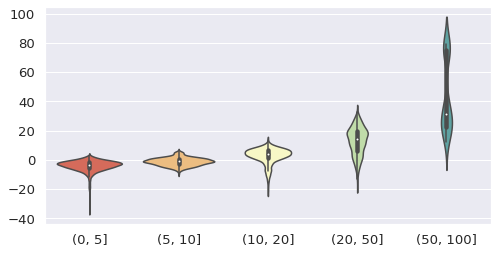

In [34]:
# Plots of residuals versus predicted values
sns.set(font_scale=1.2)
sns.violinplot(data=pre_T_exp[list(pre_T_exp.columns)[1:]], inner="box", palette="Spectral")
sns.set(rc={'figure.figsize':(8,4)})
plt.show()

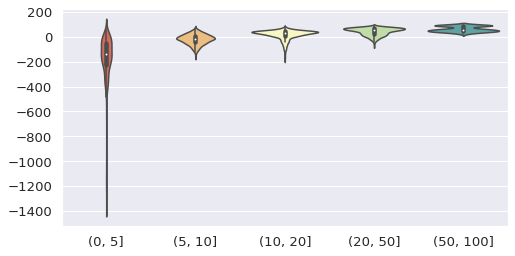

In [35]:
# Plots of relative residuals (in %) versus predicted values
sns.set(font_scale=1.2)
sns.violinplot(data=pre_rel_T_exp[(pre_rel_T_exp.columns)[1:]], inner="box", palette="Spectral")
sns.set(rc={'figure.figsize':(8,4)})
plt.show()

# ***Creating final XGBoost model using all obs. for its training***

In [36]:
# Generate test and training samples
f_X_train = X
f_y_train = y

In [37]:
# Implementation of the scikit-learn API for XGBoost regression
f_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=p1, gamma=p2, learning_rate=p3, 
                          max_depth=p4, n_estimators=p5, subsample=p6, eval_metric=["rmse"])

In [38]:
# Fitting the model 
f_xgb_model.fit(f_X_train, f_y_train, early_stopping_rounds=20, eval_set=[(f_X_train, f_y_train)])
# learning dynamics
f_y_pred = f_xgb_model.predict(f_X_train, ntree_limit=f_xgb_model.best_ntree_limit)

[0]	validation_0-rmse:1.83150
[1]	validation_0-rmse:1.69126
[2]	validation_0-rmse:1.56385
[3]	validation_0-rmse:1.45305
[4]	validation_0-rmse:1.35177
[5]	validation_0-rmse:1.26714
[6]	validation_0-rmse:1.19491
[7]	validation_0-rmse:1.12894
[8]	validation_0-rmse:1.07173
[9]	validation_0-rmse:1.01895
[10]	validation_0-rmse:0.97729
[11]	validation_0-rmse:0.94076
[12]	validation_0-rmse:0.90798
[13]	validation_0-rmse:0.88149
[14]	validation_0-rmse:0.85843
[15]	validation_0-rmse:0.84004
[16]	validation_0-rmse:0.81705
[17]	validation_0-rmse:0.80155
[18]	validation_0-rmse:0.79012
[19]	validation_0-rmse:0.77471
[20]	validation_0-rmse:0.76295
[21]	validation_0-rmse:0.75161
[22]	validation_0-rmse:0.74285
[23]	validation_0-rmse:0.73374
[24]	validation_0-rmse:0.72244
[25]	validation_0-rmse:0.71703
[26]	validation_0-rmse:0.71272
[27]	validation_0-rmse:0.70552
[28]	validation_0-rmse:0.70160
[29]	validation_0-rmse:0.69710
[30]	validation_0-rmse:0.69337
[31]	validation_0-rmse:0.68907
[32]	validation_0-

In [39]:
# Iteration with the best result
f_optimal_n = f_xgb_model.best_ntree_limit-1
print("The best iteration: " + str(f_optimal_n))    

The best iteration: 78


In [40]:
# Preparing data for building a learning graph
f_results = f_xgb_model.evals_result()

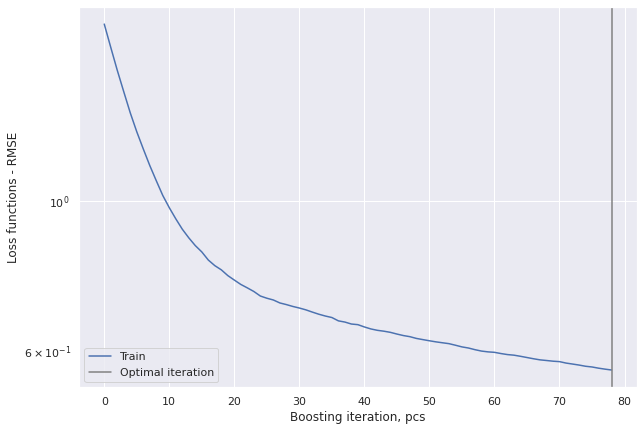

In [41]:
# Learning curves for the XGBoost model 
plt.figure(figsize=(10,7))
plt.yscale("log")
plt.plot(f_results['validation_0']['rmse'], label='Train')
plt.axvline(f_optimal_n, color="gray", label="Optimal iteration")
plt.xlabel("Boosting iteration, pcs")
plt.ylabel("Loss functions - RMSE")
plt.legend()

# Estimation of a final XGBoost model

In [42]:
# Convert data to 'array' type
f_conv_y_pred = pd.DataFrame(f_y_pred) # Double transformation
f_y_pred2 = f_conv_y_pred.values
f_y_train2 = f_y_train.values

# Intermediate results
f_n_sample = len(f_y_pred2)
f_main_sample = f_y_train.sum() / f_n_sample

# Calculation of bias
f_diff = f_y_pred2 - f_y_train2
f_bias = f_diff.sum()/f_n_sample
print('Bias: %.1f' % (f_bias))
print("Relative bias(%):", " %.2f" % (f_bias/f_main_sample*100))

# Calculation of RMSE
f_rmse = np.sqrt(mean_squared_error(f_y_train, f_y_pred))
print("RMSE: %.1f" % (f_rmse))
print("Relative RMSE(%):", " %.3f" % (f_rmse/f_main_sample*100))

# Calculation of MSE
f_mse = mean_squared_error(f_y_train, f_y_pred)
print("MSE: %.1f" % (f_mse))

# Calculation of Square R
f_R_square = r2_score(f_y_train, f_y_pred)
print("R square: %.1f%%" % (f_R_square * 100.0))

Bias: 0.0
Relative bias(%):  0.32
RMSE: 0.6
Relative RMSE(%):  25.045
MSE: 0.3
R square: 66.7%


In [43]:
# Convert input data
f_x_train_conv = np.array(f_y_train)
f_x_train_convert = np.array([None]*f_n_sample)
for i in range(f_n_sample):
    f_x_train_convert[i] = float(f_x_train_conv[i])

x_plot = f_x_train_convert
y_plot = f_y_pred
n = len(y_plot)

# Function for fitting a linear curve and estimating its parameters
def f(x_plot, a0, a1):
    return a0 + a1 * x_plot

popt, pcov = curve_fit(f, x_plot, y_plot)

R^2: 0.695
Uncertainty
a0: 1.00+/-0.06
a1: 0.556+/-0.026


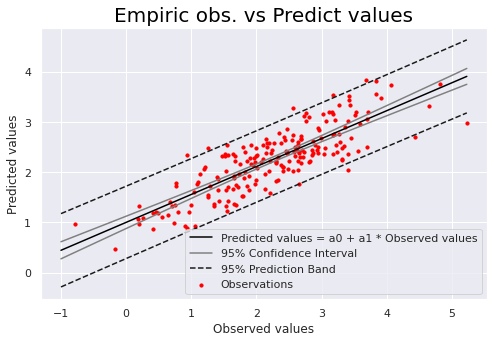

In [45]:
# Building linear a graph and calculation uncertainties

# retrieve parameter values
a0 = popt[0]
a1 = popt[1]

# compute r^2
r2 = 1.0-(sum((y_plot-f(x_plot, a0, a1)) ** 2)/((n - 1.0)*np.var(y_plot, ddof = 1)))
print(f'R^2: {r2:.3f}')

# calculate parameter confidence interval
a0, a1 = unc.correlated_values(popt, pcov)
print('Uncertainty')
print('a0: ' + str(a0))
print('a1: ' + str(a1))

# plot data
plt.figure(figsize =(8, 5))
plt.scatter(x_plot, y_plot, s = 10, c = 'red', label='Observations', marker = 'o')
plt.yscale('linear')

# estimation uncertenlies intervals
def predband(x_plot, xd, yd, p, func, conf=0.95):
    # x_plot = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x_plot - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x_plot, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

# calculate regression confidence interval
px = np.linspace(-1, max(x_plot), 100)
py = a0 + a1 * px
nom = unp.nominal_values(py)
std = unp.std_devs(py)

lpb, upb = predband(px, x_plot, y_plot, popt, f, conf=0.95)

# plot the regression
plt.plot(px, nom, c='black', label='Predicted values = a0 + a1 * Observed values')

# uncertainty lines (95% confidence)
plt.plot(px, nom - 1.96 * std, c='gray',\
         label='95% Confidence Interval')
plt.plot(px, nom + 1.96 * std, c='gray')

# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('Predicted values')
plt.xlabel('Observed values')
plt.grid(True)
plt.legend(loc='best')
plt.title('Empiric obs. vs Predict values', fontsize=20, color="black")
plt.show()

# ***Analisys output final model***

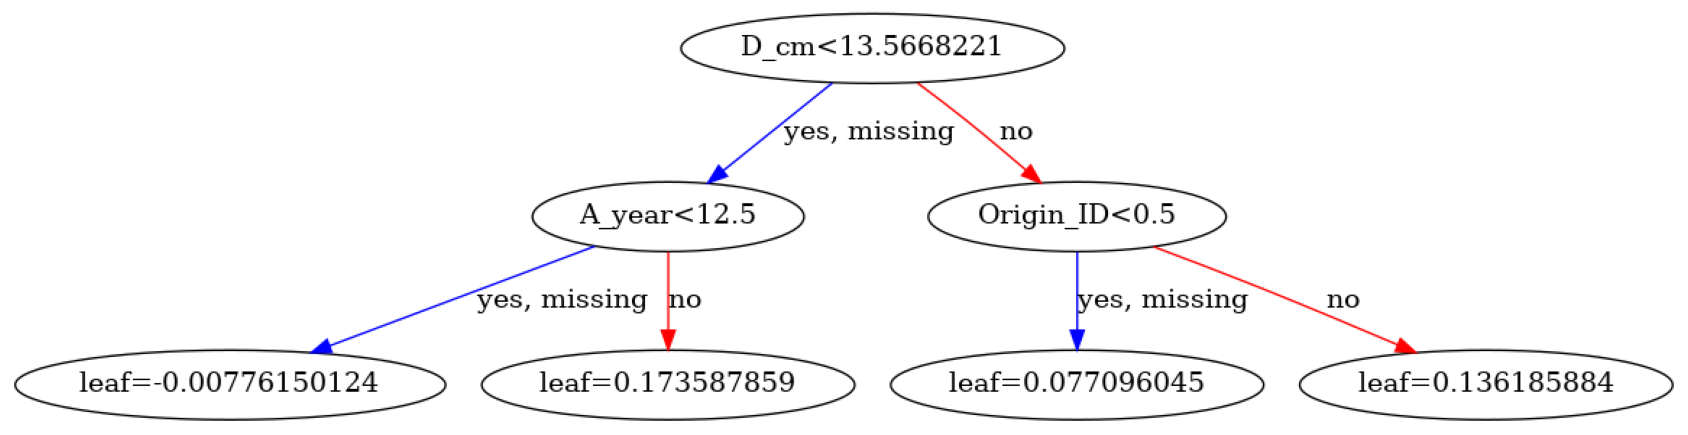

In [47]:
# Visualize the Decision tree (individual obs.)
xgb.plot_tree(f_xgb_model, num_trees=3) # "num_trees" is number of obs.
plt.rcParams['figure.figsize'] = [30, 45]
plt.show()

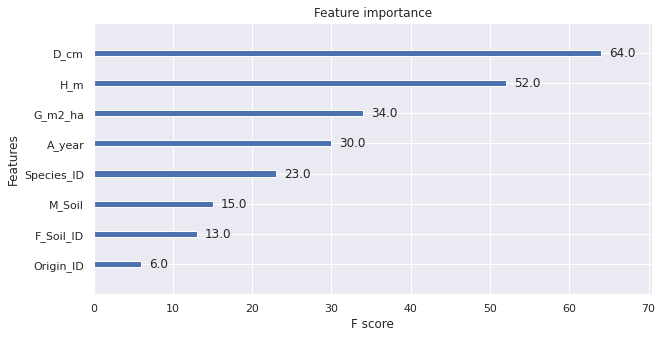

In [49]:
# Importance is calculated as: ”weight” is the number of times a feature appears in a trees
xgb.plot_importance(f_xgb_model, importance_type='weight')
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

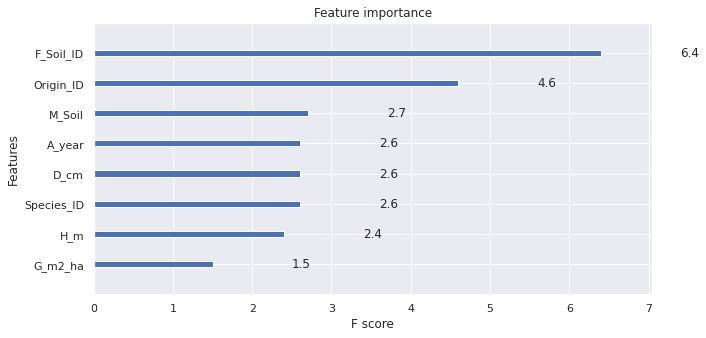

In [50]:
# Importance is calculated as: ”gain” is the average gain of splits which use the feature
# Get the booster from the xgbmodel
booster = f_xgb_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key], 1)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, importance_type='gain', show_values=True)

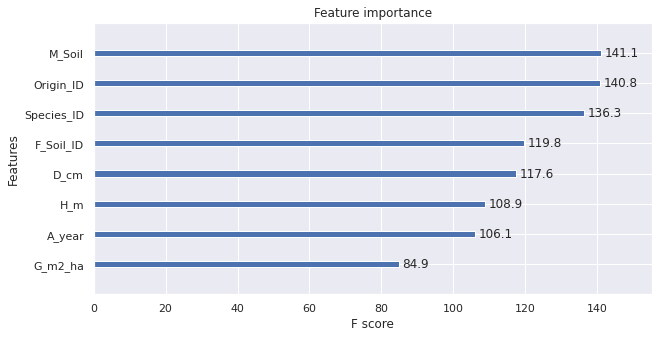

In [51]:
# Importance is calculated as: "cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split
# Get the booster from the xgbmodel
booster = f_xgb_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="cover")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key],1)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, importance_type='cover', show_values=True)

# Est. of SHAP values for final models

In [52]:
# Сreate an уxplainer object
explainer = shap.TreeExplainer(f_xgb_model)
shap_values = explainer.shap_values(f_X_train)

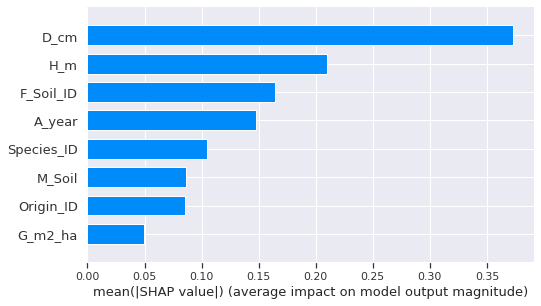

In [53]:
# Mean absolute value of the SHAP values for each feature 
shap.summary_plot(shap_values, f_X_train, plot_type="bar")

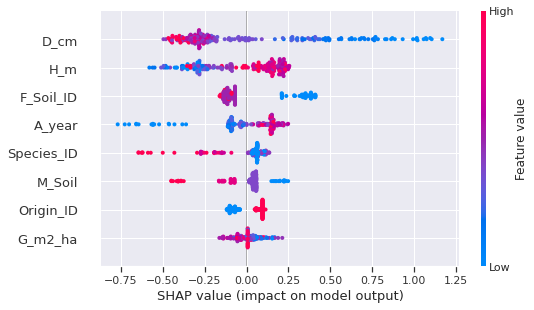

In [54]:
# Graph that summarises the effects of all the features
shap.summary_plot(shap_values, f_X_train)

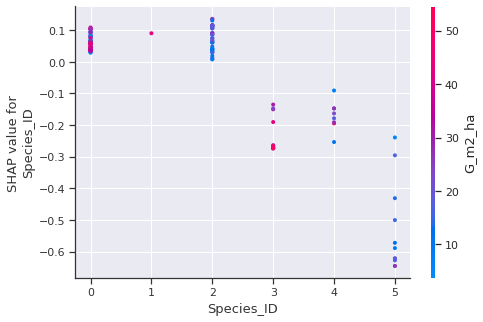

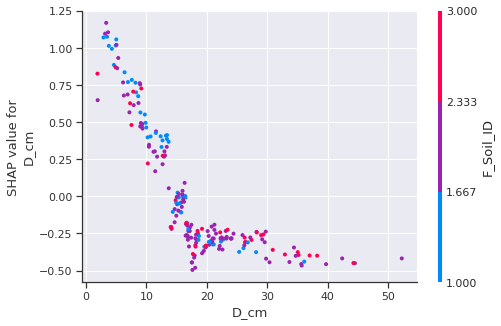

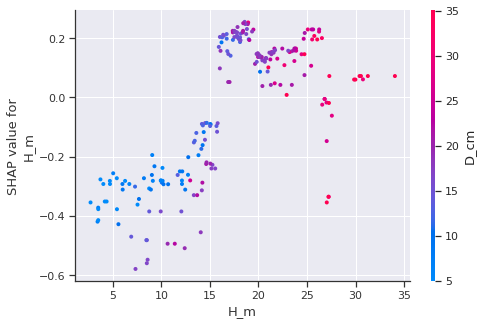

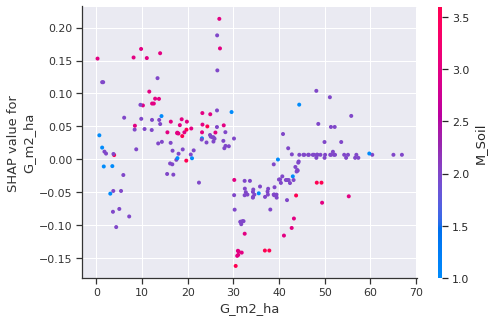

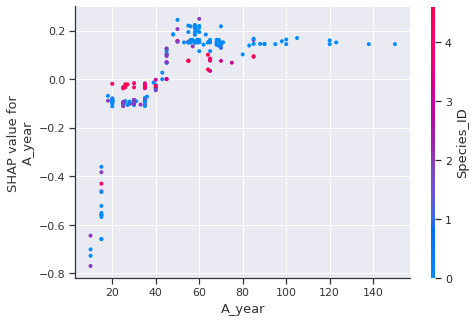

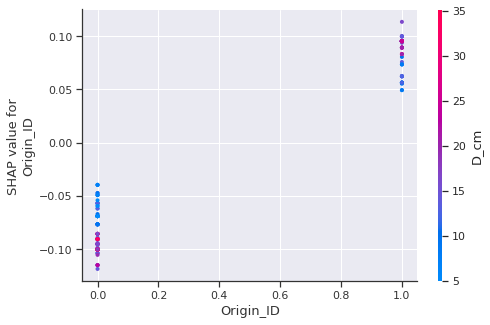

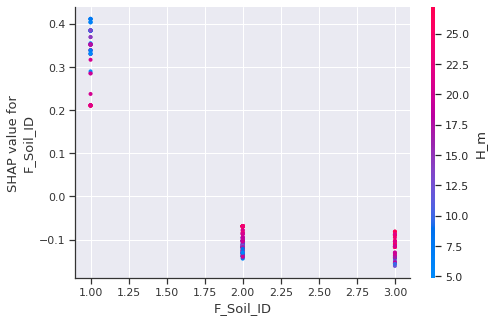

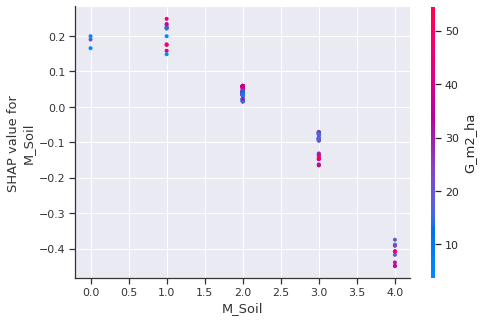

In [55]:
# Create a dependence scatter plot to show the effect of a single feature across the whole dataset
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, f_X_train, color=shap_values)

# *Save XGBoost model*

In [56]:
# Save to JSON
f_xgb_model.save_model("../02_output_data/XGBoost_models/03_LN_Tag_Sr_XGB_model_2024_final.json")
# Save to text format
f_xgb_model.save_model("../02_output_data/XGBoost_models/03_LN_Tag_Sr_XGB_model_2024_final.txt")